
<center>
    <h1><font color=darkred> CS532 : Project </font></h1>
    <h1><font color=darkred> Department of Industrial and Systems Engineering </font></h1>
    <h1><font color=darkred> Codanda Devaiah Monappa </font></h1>
    <h5>Fall 2020</h5>
    <hr>
 
</center>


In [1]:
from scipy.io import loadmat
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#this allows plots to be displayed in line
%matplotlib inline 

In [2]:
def ista_solve_hot( A, d, la_array ):
    # ista_solve_hot: Iterative soft-thresholding for multiple values of
    # lambda with hot start for each case - the converged value for the previous
    # value of lambda is used as an initial condition for the current lambda.
    # this function solves the minimization problem
    # Minimize |Ax-d|_2^2 + lambda*|x|_1 (Lasso regression)
    # using iterative soft-thresholding.
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w[:,0:1]
            if np.linalg.norm(w - w_old) < tol:
                break
    return X

In [3]:
def error_rate(A,B):
    count = 0
    for i in range(len(A)):
        if A[i] != B[i]:
            count = count + 1
    
    return count/len(A) * 100

def flat_values(sig, tv):
    """
    :param sig: signal.
    :param tv: threshold value.
    :return:
    """
    for i in np.arange(np.size(sig)):
        if sig[i] < tv:
            sig[i] = -1
        else:
            sig[i] = 1
    return sig

In [4]:
def ridge(X,y,lamda):
    w = [0,0,0,0,0,0,0,0]
    for i in range(8):
        #Using Regularized LS via Ridge Regression
        w[i] = np.linalg.inv(X.transpose()@X + (lamda[i]*np.identity(len(X.transpose()))))@X.transpose()@y
    return w

In [5]:
def low_rank(X,y):
    w = [0,0,0,0,0,0,0,0]
    U,s,VT = np.linalg.svd(X,full_matrices=False)
    for i in range(8):
        U1 = U[:,:i]
        VT1 = VT[:i,:]
        s1 = s[:i]        
        s1 = np.diag(s1)

        w[i] = (VT1.transpose()@np.linalg.inv(s1)@U1.transpose())@y
    return w

# Exploratory Data Analysis of the Wisconsin Breasts Cancer Dataset

In [6]:
df = pd.read_csv('data.csv')
df.head() 

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
df.shape

(569, 33)

In [8]:
df['target'] = (df['diagnosis'] == 'M').astype(int)

In [9]:
X1 = df.loc[:, 'radius_mean':'fractal_dimension_worst']
y1 = df['target']

In [10]:
#Correlation matrix Heatmap

corr = X1.corr()
corr.style.background_gradient(cmap='coolwarm')

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


In [11]:
X_scatter = X1.iloc[:, 0:9]

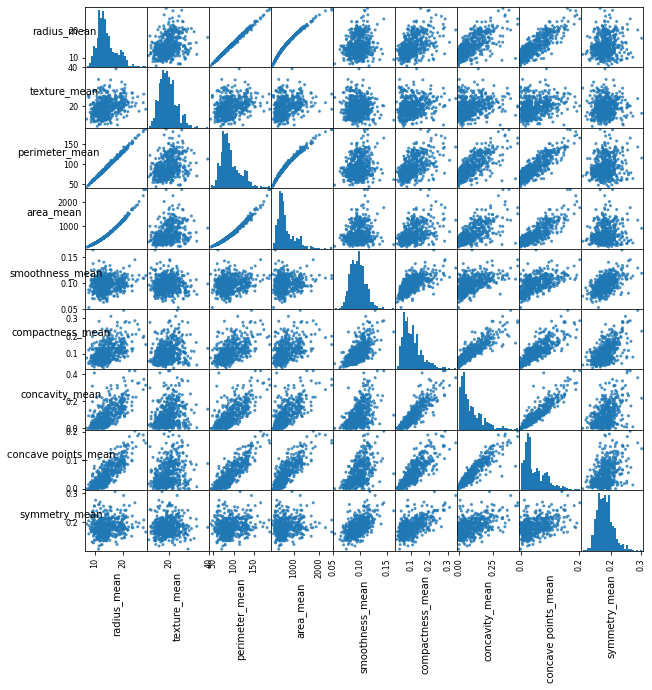

In [12]:
#Scatter Matrix First 10 features
from pandas.plotting import scatter_matrix

scatter_matrix = scatter_matrix(X_scatter, figsize=[10, 10], marker= ".", alpha=0.8, hist_kwds={'bins':30})

#adjusting the labels' font and position
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0)

In [13]:
df_n = df[df['diagnosis'] == "B"]
df_y = df[df['diagnosis'] == "M"]

# Create list of features related to mean tumor characteristics
features_means =list(df.columns[0:10])

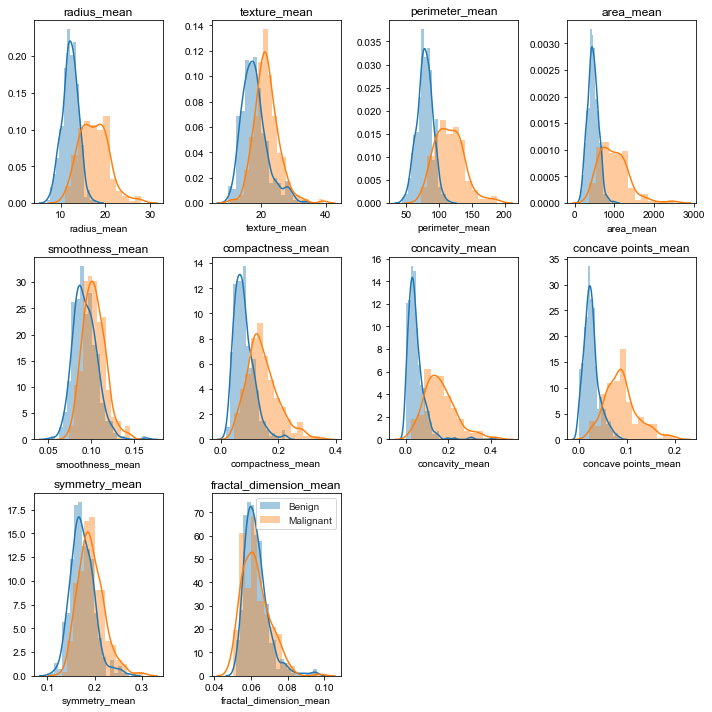

In [14]:
fig = plt.figure(figsize=(10, 10))

# Create 'for loop' to enerate though tumor features and compare with histograms
for i,b in enumerate(list(X1.columns[0:10])):
    
    # Enumerate starts at index 0, need to add 1 for subplotting
    i +=1
    
    # Create axes object for position i
    ax = fig.add_subplot(3,4,i)
    
    # Plot via histogram tumor charateristics using stacked and alpha parameters for..
    # comparisons.
    sns.distplot(df_n[b], kde=True, label='Benign')
    sns.distplot(df_y[b], kde=True, label='Malignant')
   
    ax.set_title(b)

sns.set_style("whitegrid")
plt.tight_layout()
plt.legend()
plt.show()

In [15]:
#Data Normalization Using MinMax Scalar
from sklearn.preprocessing import MinMaxScaler

#Define scaler (we're using the defaults here)
MMS = MinMaxScaler()

#Apply transformation - note that this creates a numpy array so we lose the column names
T = MMS.fit_transform(X1)


#Change the numpy array back to a dataframe and recover the column names
X1 = pd.DataFrame(T, columns = X1.columns)


#Print first five rows
X1.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [16]:
outcome_count = df.diagnosis.value_counts()
outcome_count

B    357
M    212
Name: diagnosis, dtype: int64

Text(0.5, 1.0, 'Diagnosis vs radius_mean')

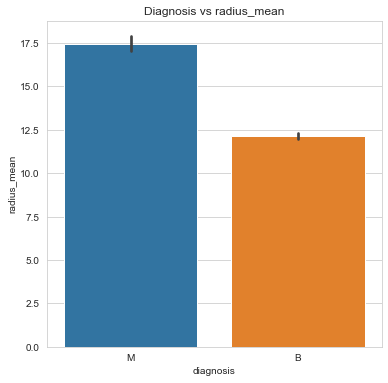

In [17]:
# Malign cells have greater radius than benign cells

fig = plt.figure(figsize = (6,6))
sns.barplot(x = 'diagnosis', y = 'radius_mean', data = df)

plt.title('Diagnosis vs radius_mean')

Text(0.5, 1.0, 'Diagnosis vs concave points_mean')

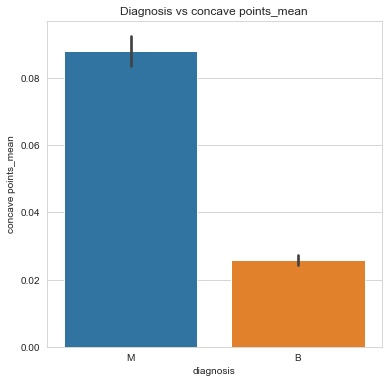

In [18]:
# Malign cells have much greater concave points_mean than benign cells

fig = plt.figure(figsize = (6,6))
sns.barplot(x = 'diagnosis', y = 'concave points_mean', data = df)

plt.title('Diagnosis vs concave points_mean')

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.25, random_state = 16)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
log_reg = LogisticRegression()

log_reg.fit(x_train, y_train)

# Evalaute RFC with test data
log_reg_predicted = log_reg.predict(x_test)
print('Model accuracy on test data: {}'.format(accuracy_score(y_test, log_reg_predicted)))

Model accuracy on test data: 0.9790209790209791


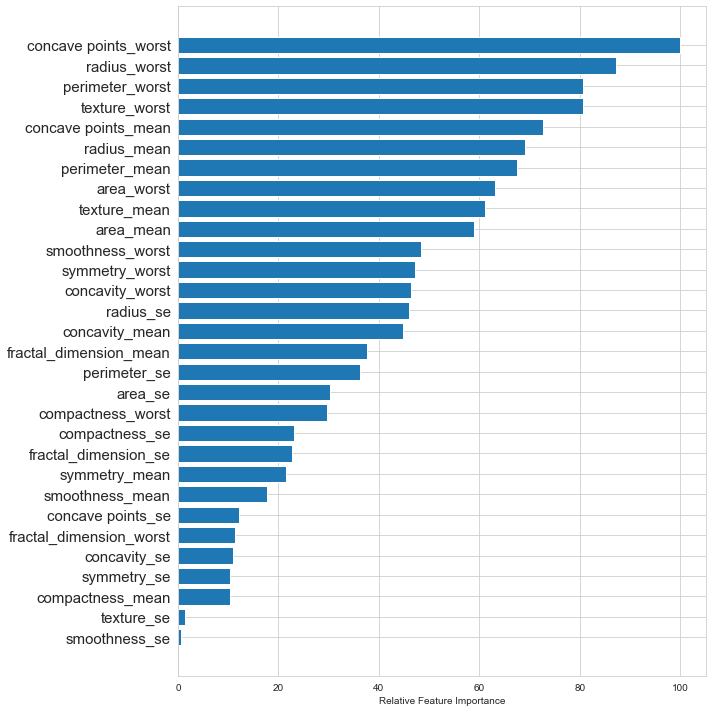

In [21]:
feature_importance = abs(log_reg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X1.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()  
plt.show()

# Model Development and Prediction

In [22]:
## Breast Cancer LASSO Exploration
## Prepare workspace

X = X1.to_numpy()
y = y1.to_numpy()

##  10-fold CV 

setindices = [[1,56],[57,112],[113,168],[169,224],[225,280],[281,336],[337,392],[393,448],[449,504],[505,569]]

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions
#
# 
#
lam_vals = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 50]

avg_rate = [0,0,0,0,0,0,0,0]
avg_error = [0,0,0,0,0,0,0,0]

# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set
    At = X[trn_ind,:]
    bt = y[trn_ind]
    
    print("\n",len(v1_ind), len(v2_ind), len(trn_ind))
# Use training data to learn classifier
    W = ista_solve_hot(At,bt,lam_vals),
    W = W[0]
    
    error_rate = [0,0,0,0,0,0,0,0]
    
    for i in range(0,8):
        d_predict = (Av1@W[:,i])
        d_predict = d_predict.reshape(-1, 1)
        d_predict = flat_values(d_predict,0)
        count = 0
        for k in range(len(d_predict)):
            if d_predict[k] != bv1[k]:
                count = count + 1
        error_rate[i] = count/len(d_predict) * 100

    d_predict = (Av2@W[:,(np.argmin(error_rate))])
    d_predict = d_predict.reshape(-1, 1)
    d_predict = flat_values(d_predict,0)
    count = 0
    for k in range(len(d_predict)):
        if d_predict[k] != bv2[k]:
            count = count + 1
    
    pred_error = count/len(d_predict) * 100
    error = d_predict - bv2
    
    
    print("\nLASSO: Index of best lamda values:",np.argmin(error_rate))
    print("Best Lamda value on Validation dataset=",lam_vals[np.argmin(error_rate)])
    print("Prediction error rate on test dataset =",pred_error,"%")
    print("2 norm residual error =",LA.norm(error, 2))
    
    avg_rate[j] = pred_error
    avg_error[j] = LA.norm(error, 2)
# Find best lambda value using first validation set, then evaluate
# performance on second validation set, and accumulate performance metrics
# over all cases partitions





 56 56 183

LASSO: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 58.92857142857143 %
2 norm residual error = 42.98837052040938

 56 56 183

LASSO: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 64.28571428571429 %
2 norm residual error = 44.899888641287305

 56 56 183

LASSO: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 48.214285714285715 %
2 norm residual error = 38.884444190447155

 56 56 183

LASSO: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 55.35714285714286 %
2 norm residual error = 41.66533331199932

 56 56 224

LASSO: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 76.78571428571429 %
2 norm residual error = 49.07137658554114

 56 56

In [23]:
print("LASSO:")
print("Average misclassification rate =",np.mean(avg_rate))
print("Average squared error =",np.mean(avg_error))

LASSO:
Average misclassification rate = 59.61538461538462
Average squared error = 43.55111354777051


In [24]:
## Breast Cancer RIDGE Exploration
## Prepare workspace
X = X1.to_numpy()
y = y1.to_numpy()

##  10-fold CV 

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]]

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions
#
# 
#
lam_vals = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 50]

avg_rate = [0,0,0,0,0,0,0,0]
avg_error = [0,0,0,0,0,0,0,0]

# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set
    At = X[trn_ind,:]
    bt = y[trn_ind]
    
    print("\n",len(v1_ind), len(v2_ind), len(trn_ind))
# Use training data to learn classifier
    W = ridge(At,bt,lam_vals)
    
    error_rate = [0,0,0,0,0,0,0,0]
    
    for i in range(0,8):
        d_predict = (Av1@W[i])
        d_predict = d_predict.reshape(-1, 1)
        d_predict = flat_values(d_predict,0)
        count = 0
        for k in range(len(d_predict)):
            if d_predict[k] != bv1[k]:
                count = count + 1
        error_rate[i] = count/len(d_predict) * 100

    d_predict = (Av2@W[(np.argmin(error_rate))])
    d_predict = d_predict.reshape(-1, 1)
    d_predict = flat_values(d_predict,0)
    count = 0
    for k in range(len(d_predict)):
        if d_predict[k] != bv2[k]:
            count = count + 1
    
    pred_error = count/len(d_predict) * 100
    error = d_predict - bv2
    
    
    print("\nRIDGE: Index of best lamda values:",np.argmin(error_rate))
    print("Best Lamda value on Validation dataset=",lam_vals[np.argmin(error_rate)])
    print("Prediction error rate on test dataset =",pred_error,"%")
    print("2 norm residual error =",LA.norm(error, 2))
    
    avg_rate[j] = pred_error
    avg_error[j] = LA.norm(error, 2)
# Find best lambda value using first validation set, then evaluate
# performance on second validation set, and accumulate performance metrics
# over all cases partitions



 30 30 235

RIDGE: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 36.666666666666664 %
2 norm residual error = 18.97366596101028

 30 30 235

RIDGE: Index of best lamda values: 3
Best Lamda value on Validation dataset= 0.01
Prediction error rate on test dataset = 53.333333333333336 %
2 norm residual error = 22.962387036230645

 30 30 235

RIDGE: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 66.66666666666666 %
2 norm residual error = 26.354476682855175

 30 30 235

RIDGE: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 60.0 %
2 norm residual error = 23.401963817339247

 30 29 236

RIDGE: Index of best lamda values: 0
Best Lamda value on Validation dataset= 1e-05
Prediction error rate on test dataset = 68.96551724137932 %
2 norm residual error = 25.794401679592003

 29 29 237

RIDGE

In [25]:
print("RIDGE:")
print("Average misclassification rate =",np.mean(avg_rate))
print("Average squared error =",np.mean(avg_error))

RIDGE:
Average misclassification rate = 54.19540229885057
Average squared error = 22.608339744485605


In [26]:
## Breast Cancer Low Rank Approximation
## Prepare workspace

X = X1.to_numpy()
y = y1.to_numpy()

##  10-fold CV 

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]]

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions
#
# 
#
rank_vals = [1,2,3,4,5,6,7,8]

avg_rate = [0,0,0,0,0,0,0,0]
avg_error = [0,0,0,0,0,0,0,0]

# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set
    At = X[trn_ind,:]
    bt = y[trn_ind]
    
    print("\n",len(v1_ind), len(v2_ind), len(trn_ind))
# Use training data to learn classifier
    W = low_rank(At,bt)
    
    error_rate = [0,0,0,0,0,0,0,0]
    
    for i in range(0,8):
        d_predict = (Av1@W[i])
        d_predict = d_predict.reshape(-1, 1)
        d_predict = flat_values(d_predict,0)
        count = 0
        for k in range(len(d_predict)):
            if d_predict[k] != bv1[k]:
                count = count + 1
        error_rate[i] = count/len(d_predict) * 100

    d_predict = (Av2@W[(np.argmin(error_rate))])
    d_predict = d_predict.reshape(-1, 1)
    d_predict = flat_values(d_predict,0)
    count = 0
    for k in range(len(d_predict)):
        if d_predict[k] != bv2[k]:
            count = count + 1
    
    pred_error = count/len(d_predict) * 100
    error = d_predict - bv2
    
    
    print("\nTruncated: Index of best low-rank approximation:",np.argmin(error_rate))
    print("Best Low-rank approximation on Validation dataset=",lam_vals[np.argmin(error_rate)])
    print("Prediction error rate on test dataset =",pred_error,"%")
    print("2 norm residual error =",LA.norm(error, 2))
    
    avg_rate[j] = pred_error
    avg_error[j] = LA.norm(error, 2)
# Find best lambda value using first validation set, then evaluate
# performance on second validation set, and accumulate performance metrics
# over all cases partitions



 30 30 235

Truncated: Index of best low-rank approximation: 0
Best Low-rank approximation on Validation dataset= 1e-05
Prediction error rate on test dataset = 33.33333333333333 %
2 norm residual error = 17.320508075688775

 30 30 235

Truncated: Index of best low-rank approximation: 0
Best Low-rank approximation on Validation dataset= 1e-05
Prediction error rate on test dataset = 53.333333333333336 %
2 norm residual error = 21.908902300206645

 30 30 235

Truncated: Index of best low-rank approximation: 0
Best Low-rank approximation on Validation dataset= 1e-05
Prediction error rate on test dataset = 66.66666666666666 %
2 norm residual error = 24.49489742783178

 30 30 235

Truncated: Index of best low-rank approximation: 0
Best Low-rank approximation on Validation dataset= 1e-05
Prediction error rate on test dataset = 60.0 %
2 norm residual error = 23.237900077244497

 30 29 236

Truncated: Index of best low-rank approximation: 0
Best Low-rank approximation on Validation dataset= 1e

In [27]:
print("Low Rank Approximation:")
print("Average misclassification rate =",np.mean(avg_rate))
print("Average squared error =",np.mean(avg_error))

Low Rank Approximation:
Average misclassification rate = 53.7787356321839
Average squared error = 21.070272058815732
